# Retention Redshift Insert (API Method)
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [8]:
import boto3
import getpass
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import awswrangler as wr

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [9]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [10]:
lkupclientid = 11
dbname = 'stlrmilb'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34454 entries, 0 to 34453
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            34454 non-null  int64  
 1   dimCustomerMasterId     34454 non-null  int64  
 2   customerNumber          34454 non-null  object 
 3   year                    34454 non-null  int64  
 4   productGrouping         34454 non-null  object 
 5   totalSpent              34454 non-null  float64
 6   recentDate              34454 non-null  object 
 7   attendancePercent       34454 non-null  float64
 8   renewedBeforeDays       34452 non-null  float64
 9   isBuyer                 34454 non-null  object 
 10  source_tenure           34454 non-null  int64  
 11  tenure                  34452 non-null  float64
 12  distToVenue             34454 non-null  float64
 13  totalGames              34454 non-null  int64  
 14  recency                 34454 non-null

### We should specify the features used in our model:

In [11]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (26236, 11)
Unseen Data For Predictions: (4630, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [13]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [14]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7516,0.8259,0.2761,0.7923,0.4094,0.2960,0.3621,0.7600


### Let's load in our 2021 season data and get retention scores using the model:

In [15]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(3581, 11)

In [16]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

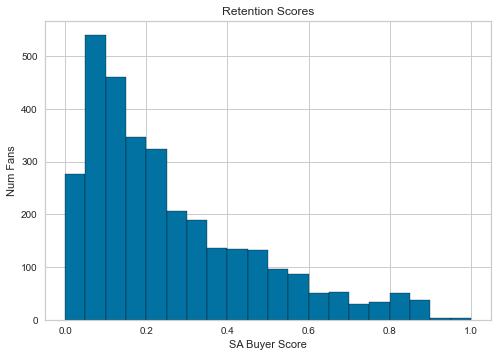

In [17]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [18]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]         3
(0.9, 0.95]         3
(0.85, 0.9]        37
(0.8, 0.85]        50
(0.75, 0.8]        33
(0.7, 0.75]        30
(0.65, 0.7]        52
(0.6, 0.65]        50
(0.55, 0.6]        87
(0.5, 0.55]        96
(0.45, 0.5]       132
(0.4, 0.45]       135
(0.35, 0.4]       136
(0.3, 0.35]       190
(0.25, 0.3]       206
(0.2, 0.25]       324
(0.15, 0.2]       347
(0.1, 0.15]       460
(0.05, 0.1]       540
(-0.001, 0.05]    277
Name: Score_1, dtype: int64

### First we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [19]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

GPHG-WFKQ
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [26]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = dbname,
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Before we insert new scores, let's grab a list of the most recent scores (currVersnFlag=1) so we can update them after the new scores are pushed:

### Insert the new scores into the customerRetentionScores table:

In [47]:
# create batches of dataframes based on batch size
batch_size = 250
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

In [72]:
print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE:")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(0)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round(row.Score_1,4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
    
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 3188 NEW RETENTION SCORES TO DATABASE:
 > INSERTED BATCH 1 : ROWS 1 - 250
 > INSERTED BATCH 2 : ROWS 251 - 500
 > INSERTED BATCH 3 : ROWS 501 - 750
 > INSERTED BATCH 4 : ROWS 751 - 1000
 > INSERTED BATCH 5 : ROWS 1001 - 1250
 > INSERTED BATCH 6 : ROWS 1251 - 1500
 > INSERTED BATCH 7 : ROWS 1501 - 1750
 > INSERTED BATCH 8 : ROWS 1751 - 2000
 > INSERTED BATCH 9 : ROWS 2001 - 2250
 > INSERTED BATCH 10 : ROWS 2251 - 2500
 > INSERTED BATCH 11 : ROWS 2501 - 2750
 > INSERTED BATCH 12 : ROWS 2751 - 3000
 > INSERTED BATCH 13 : ROWS 3001 - 3188
RETENTION SCORE INSERTS COMPLETED!


### Now let's update the old scores to currVersFlag = 0

In [ ]:
# get a list of currVersFlag = 1 : call it prevScores
# try inserting new scores (with currVersnFlag hardcoded to 1)
# if that worked, update currVersFlag for prevScores to 0
# if that failed, don't update prevScores flag to 0

### Let's query RedShift to make sure our records got into the database:

In [73]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_scores.shape[0]}")
df_scores.head()

TOTAL RECORDS: 3188


,customerretentionscoreid,dimcustomermasterid,lkupclientid,currversnflag,seasonyear,insertdate,sascore,mostrecentattendance,attendancepercentage,tenuredays,product
0,219808,357094563,11,false,2021,2022-03-21 11:03:48,0.4855,2021-09-26 00:00:00,0.585106,1825,Full Season
1,219812,357094566,11,false,2021,2022-03-21 11:03:48,0.2644,2021-08-18 00:00:00,0.019231,1825,Full Season
2,219816,357094586,11,false,2021,2022-03-21 11:03:48,0.5301,2021-09-07 00:00:00,0.317308,1825,Half Season
3,219820,357094594,11,false,2021,2022-03-21 11:03:48,0.5707,2021-08-22 00:00:00,0.444444,1825,Full Season
4,219824,357094595,11,false,2021,2022-03-21 11:03:48,0.1299,2021-05-13 00:00:00,0.142857,365,Mini Plan


### We can also use the API to delete records from the database:

In [70]:
delete_statement = f"""
    DELETE 
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

wr.data_api.redshift.read_sql_query(
    sql = delete_statement, 
    con = conn
)

""
